<a href="https://colab.research.google.com/github/POORNI-AIDA/cd/blob/main/Extreme_Gradient_Boosting_(XGBoosting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extreme Gradient Boosting

#Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit

#Loading the dataset

In [ ]:
time = pd.read_csv('PJME_hourly.csv')
time = time.set_index('Datetime')
time.index = pd.to_datetime(time.index)
time

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [ ]:
time.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


#Plot the Dataset

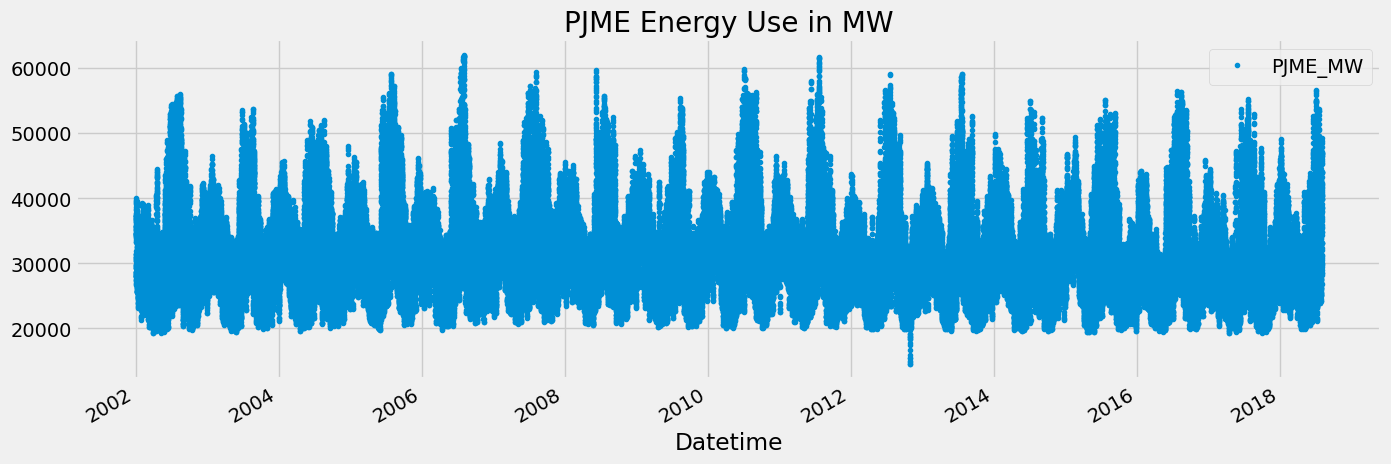

In [ ]:
time.plot(style='.',
        figsize=(15, 5),
        title='PJME Energy Use in MW')
plt.show()

#Split the data into training and testing sets

In [ ]:
train = time.loc[time.index < '01-01-2015']
test = time.loc[time.index >= '01-01-2015']

#Visualization of Train/Test Split Based on Time

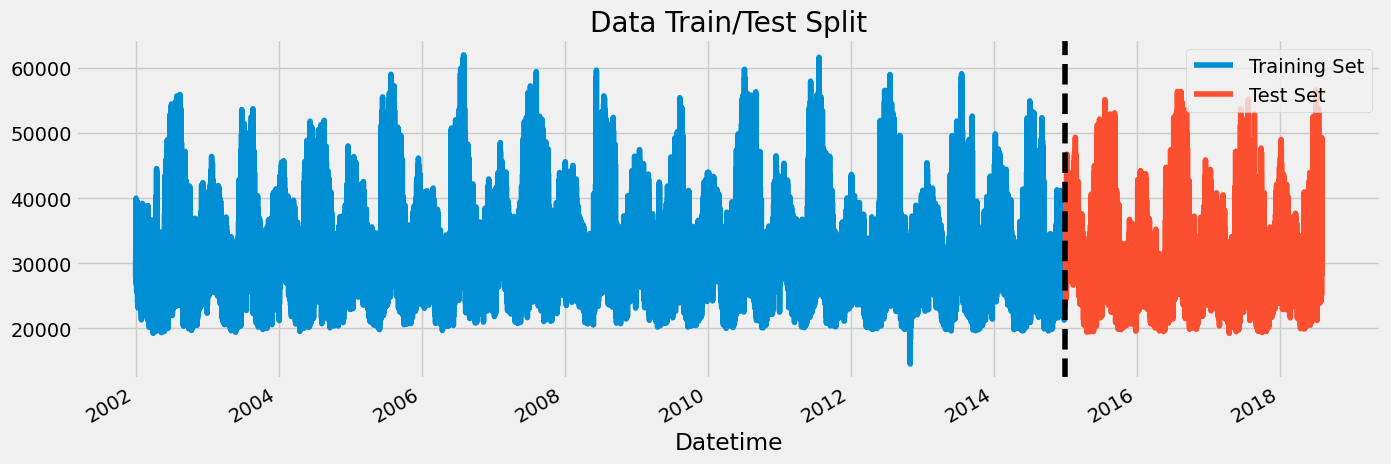

In [ ]:
train = time.loc[time.index < '01-01-2015']
test = time.loc[time.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


#Plotting a specific time range from the dataset

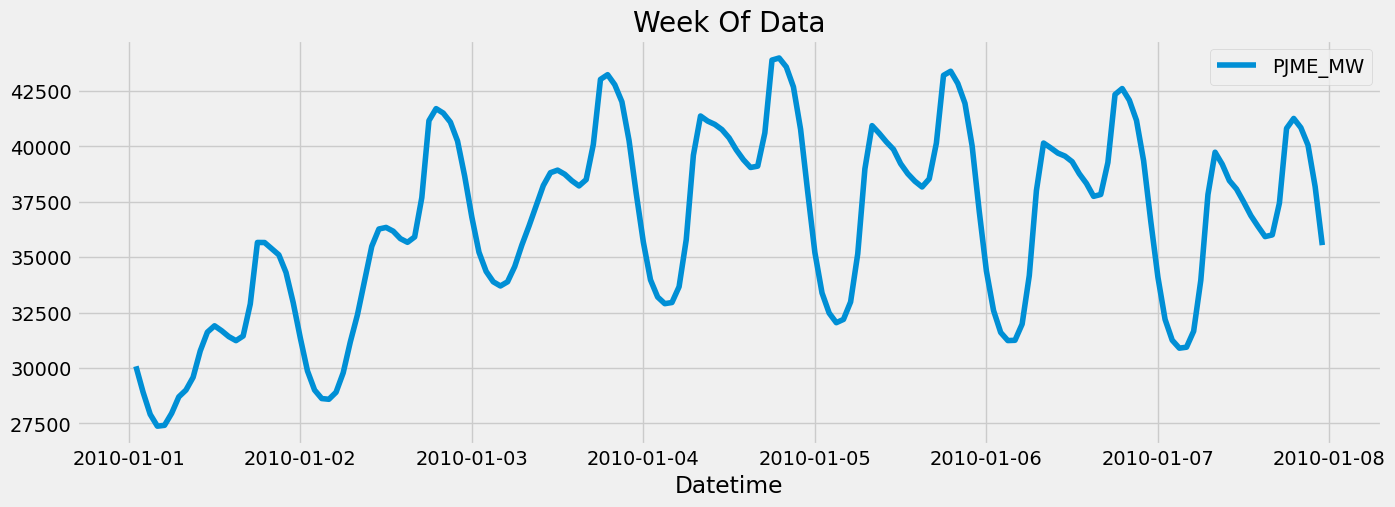

In [ ]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.lineplot(data=time.loc[(time.index > '2010-01-01') & (time.index < '2010-01-08')])
plt.title('Week Of Data')
plt.show()

#Outlier Analysis & Removal

array([[<Axes: title={'center': 'PJME_MW'}>]], dtype=object)

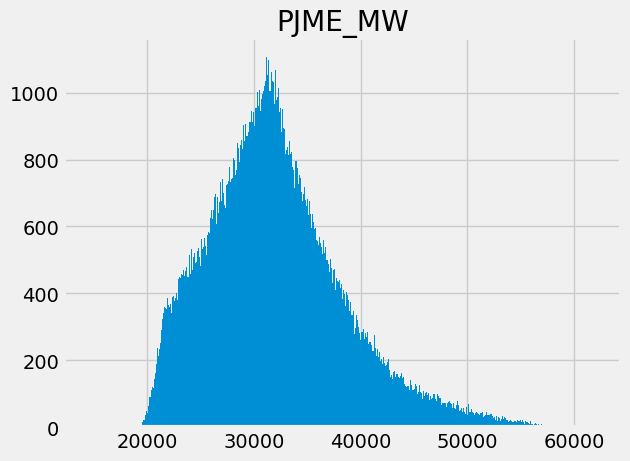

In [ ]:
time.hist(bins=500)

#Creating Time-based Features for Dataset

<Axes: xlabel='Datetime'>

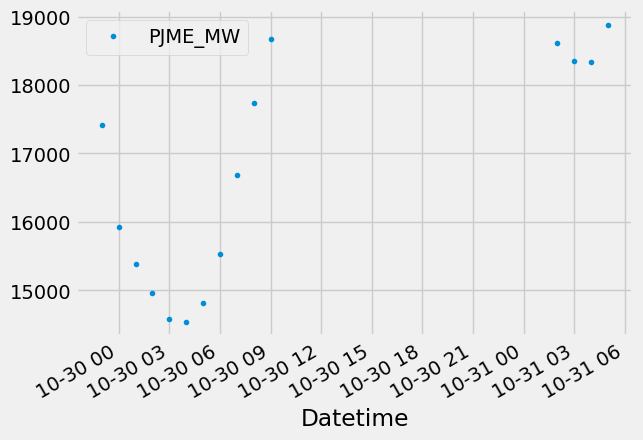

In [ ]:
time.query('PJME_MW < 19000').plot(style='.')

In [ ]:
time = time.query('PJME_MW > 19000').copy()

In [ ]:
time.min()

PJME_MW    19085.0
dtype: float64

#Time Series Cross Validation

In [ ]:
N_SPLITS  = 5
TEST_SIZE = 24*365 # WE WANT TOP PREIDICT 1 YEAR AND OUR DATA IS HOURLY

tss =TimeSeriesSplit(n_splits=N_SPLITS , test_size=TEST_SIZE ,gap= 24)

time = time.sort_index()

In [ ]:
for train_idx, val_idx in tss.split(time):
    break

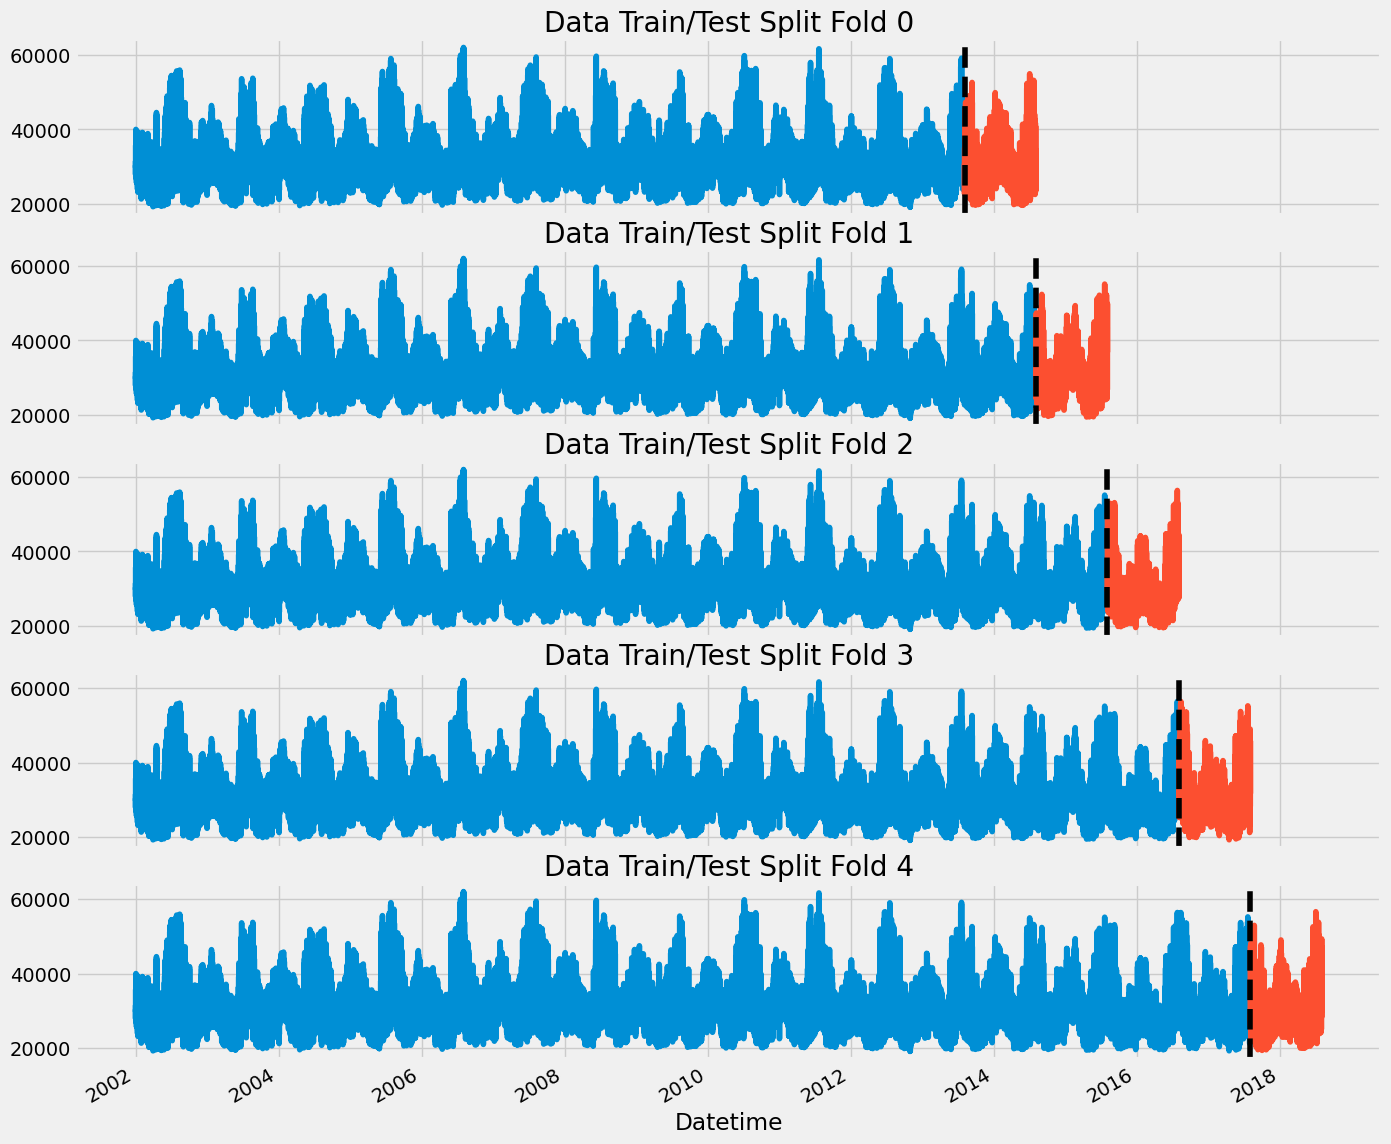

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(time):
    train = time.iloc[train_idx]
    test = time.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#Data Preprocessing

In [ ]:
def create_features(time):
    """
    Create time series features based on time series index.
    """
    time = time.copy()
    time['hour'] = time.index.hour
    time['dayofweek'] = time.index.dayofweek
    time['quarter'] = time.index.quarter
    time['month'] = time.index.month
    time['year'] = time.index.year
    time['dayofyear'] = time.index.dayofyear
    time['dayofmonth'] = time.index.day
    time['weekofyear'] = time.index.isocalendar().week
    return time
time = create_features(time)

#Visualize our Feature Dataset by Hour/Month

Text(0.5, 1.0, 'MW By Hour')

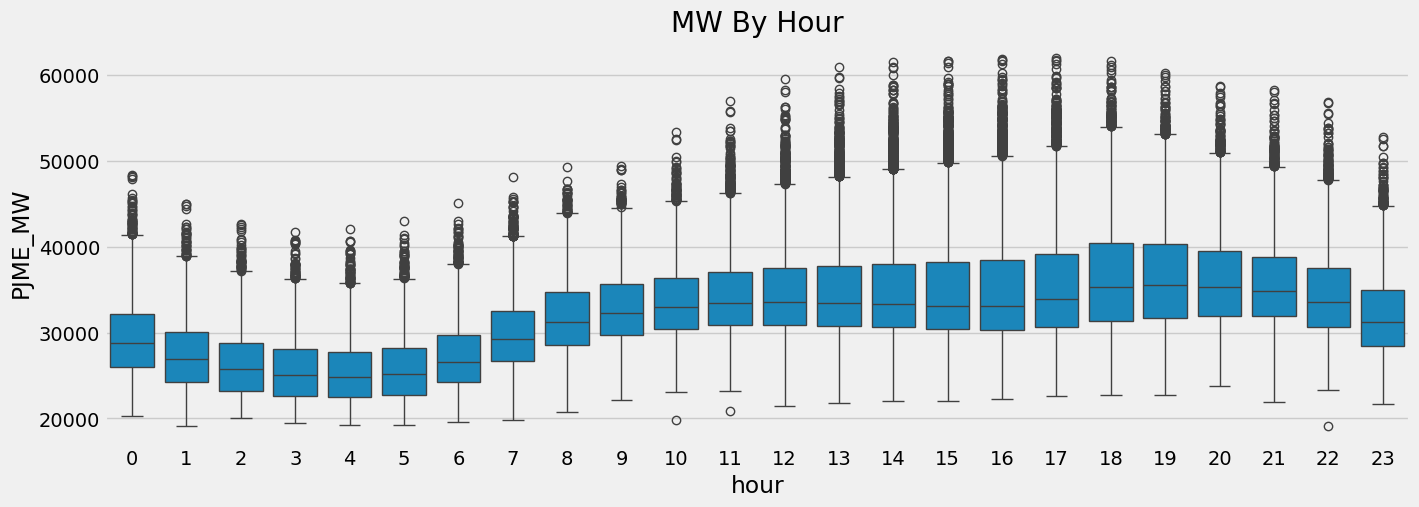

In [ ]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(time,x='hour',y='PJME_MW')
ax.set_title('MW By Hour')

Text(0.5, 1.0, 'MW By Month')

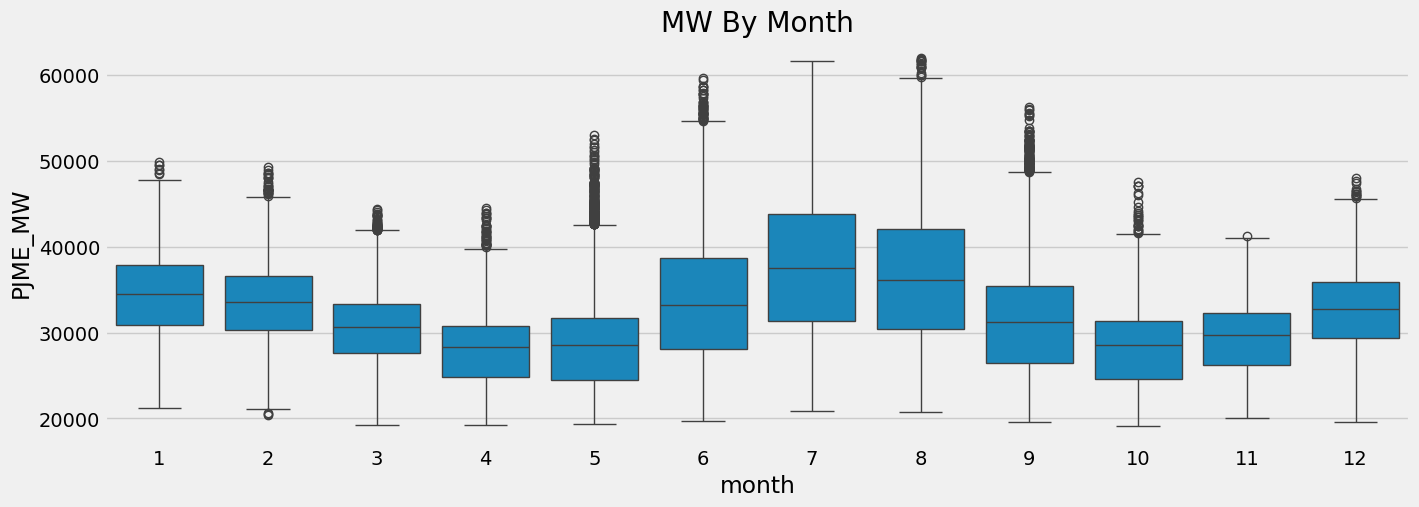

In [ ]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(time,x='month',y='PJME_MW')
ax.set_title('MW By Month')

In [ ]:
def add_lags(time):
    target_map = time['PJME_MW'].to_dict()
    time['lag1year'] = (time.index - pd.Timedelta('364 days')).map(target_map)
    time['lag2year'] = (time.index - pd.Timedelta('728 days')).map(target_map)
    time['lag3year'] = (time.index - pd.Timedelta('1092 days')).map(target_map)
    return time
time = add_lags(time)

In [ ]:
time

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1year,lag2year,lag3year
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


In [ ]:
time.isna().sum()

PJME_MW           0
hour              0
dayofweek         0
quarter           0
month             0
year              0
dayofyear         0
dayofmonth        0
weekofyear        0
lag1year       8758
lag2year      17500
lag3year      26240
dtype: int64

#Preparing Dataset and Training XGBoost Model using Cross Validation

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(time):
    train = time.iloc[train_idx]
    test = time.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1year','lag2year','lag3year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,eval_set=[(X_train, y_train),
     (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:13:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:13:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:13:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:14:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:14:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


#Train with all the data

In [ ]:
#Retrain on all data
time = create_features(time)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1year','lag2year','lag3year']
TARGET = 'PJME_MW'

X_all = time[FEATURES]
y_all = time[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:16:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#Predict into the future

In [ ]:
time.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
future = pd.date_range(start='2018-08-03',end='2019-08-01',freq='1h')
future_time = pd.DataFrame(index=future)

In [ ]:
future_time['isFuture']= True
time['isFuture']= False
df_and_future = pd.concat([time,future_time])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1year,lag2year,lag3year,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

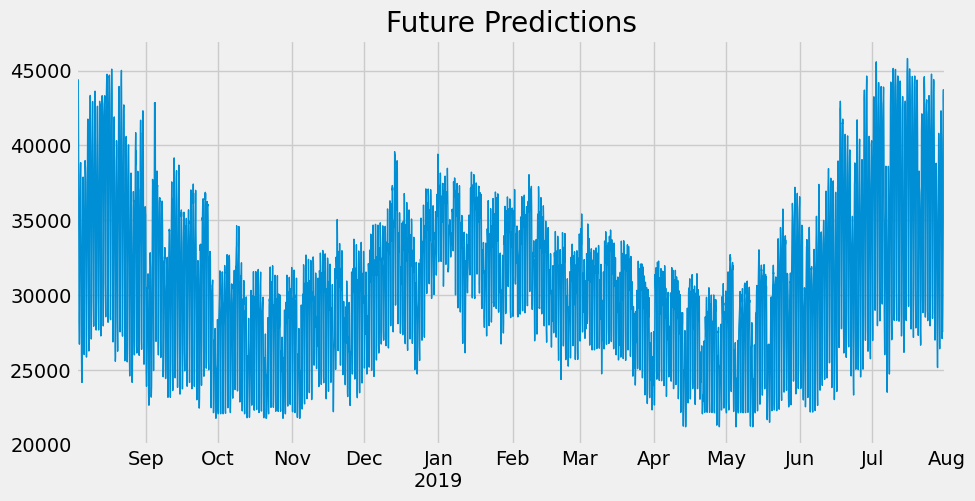

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

#Feature Importance Analysis and Predictions using XGBoost Model

Text(0.5, 1.0, 'Features Importances')

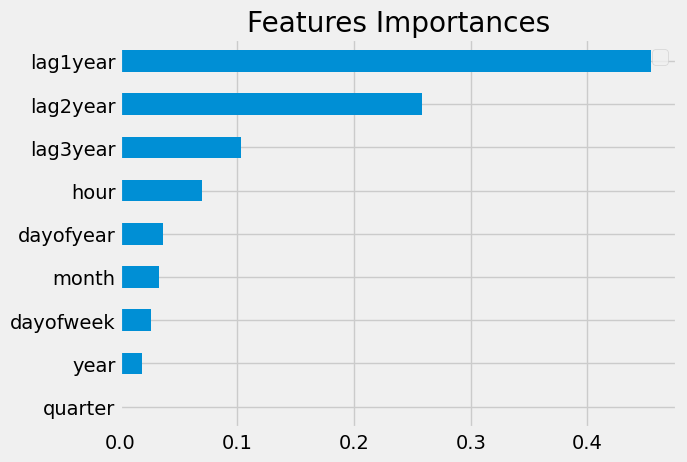

In [ ]:
feature_importances  = pd.DataFrame(data=reg.feature_importances_,index = reg.feature_names_in_,columns=['importances'])
feature_importances = feature_importances.sort_values(by = 'importances',ascending=1)
feature_importances.plot(kind='barh')
plt.legend('')
plt.title('Features Importances')

#Merging Predictions into Original Dataset

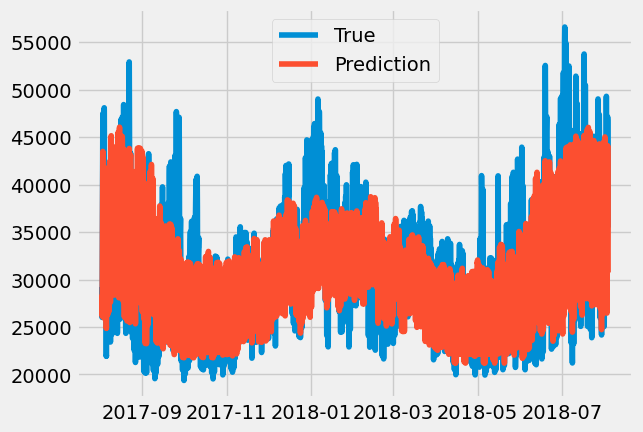

In [ ]:
test['prediciton'] = reg.predict(X_test)

plt.plot(test['PJME_MW'],label='True')
plt.plot(test['prediciton'],label='Prediction')

plt.legend()

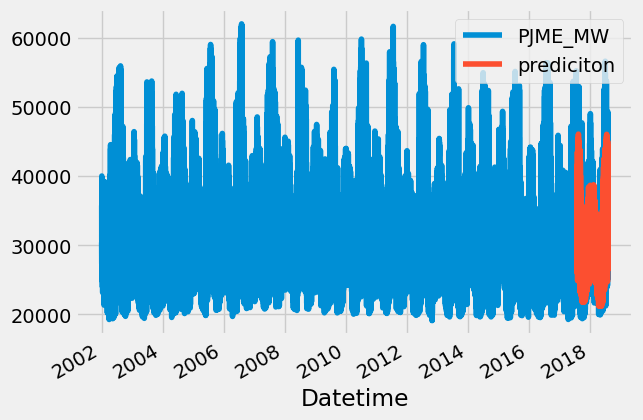

In [ ]:
time['PJME_MW'].plot()
test['prediciton'].plot()
plt.legend()

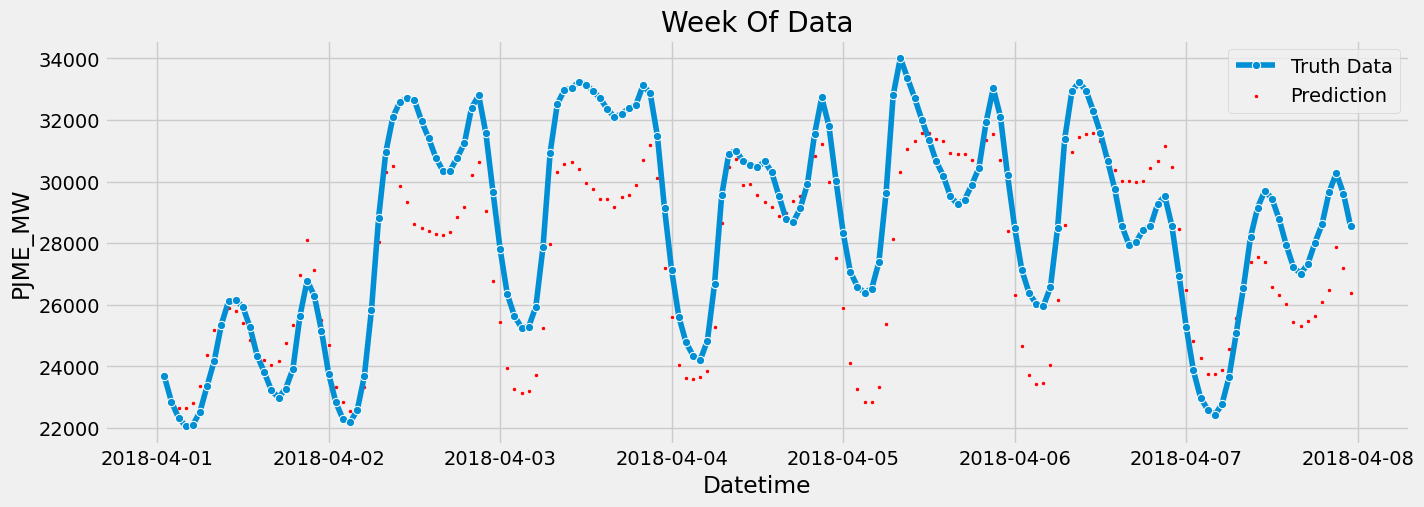

In [ ]:
# Filtering data
filtered_data = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]

# Plotting
plt.figure(figsize=(15, 5))
sns.lineplot(data=filtered_data['PJME_MW'], marker='o', label='Truth Data')
sns.scatterplot(data=filtered_data['prediciton'], marker='.', label='Prediction',color='red')
plt.title('Week Of Data')
plt.legend()
plt.show()

#Calculate the Errors and Find the Best and Worst Predictions

In [ ]:
mean_squared_error(test['PJME_MW'],test['prediciton'])

14211668.38884629

In [60]:
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score
y_pred =reg.predict(X_test)
r2_score(y_test,y_pred)

0.6127149906308456